# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# The GA-ABC class

In [15]:
class GAABC():
    def __init__(self, obj_func, bounds,
                 colony_size = 30,  # number of food source ( = employed bees )
                 limit = 10,       # couter threshold for going to scout )
                 max_iteration = 200, # max iteration steps

                 ga_interval = 10 ,  # how often to perform GA
                 ga_parents = 10 ,  # how many elite parents to mate in each GA step. 
                 mutate_rate = 0.1 ,
                 mutat_sigma = 0.1 ,
                ):
        """
        obf_func: callable, function to provide target for minimize
        bounds: 2D array, the lower/upper limit of variables, shape = D*2
        """
        self.func = obj_func # f
        self.bounds = bounds
        self.bounds_dimension = len(bounds) # D
        self.colony_size = colony_size # N
        self.limit = limit 
        self.max_iteration = max_iteration
        
        self.ga_interval = ga_interval
        self.ga_parents  = ga_parents 
        self.mutate_rate = mutate_rate
        self.mutate_sigma = mutat_sigma

    # Initial colony from random generation
    def _init_colony(self):
        lo, hi = self.bounds.T   # each is a 1D array, shape = D
        self.x = lo + (hi-lo)*np.random.rand( self.colony_size, self.bounds_dimension )  # get input X, shape = N*D
        self.y = np.apply_along_axis(self.func, 1, self.x)  
        self.trial = np.zeros( self.colony_size , int)  # trial counter
        #print( 'X : ', self.x )
        #print( 'Y : ', self.y )
        
    # Generate new candidate around solution i
    def _neighbor_search(self, i): 
        k = np.random.choice([j for j in range(self.colony_size) if j != i])
        phi = np.random.uniform(-1, 1, self.bounds_dimension)
        v = np.clip(self.x[i] + phi*(self.x[i]-self.x[k]), self.bounds[:,0], self.bounds[:,1])
        return v
        
    # Greedy update by calculating cost function
    def _greedy(self, i , cand):
        y_cand = self.func(cand)
        if y_cand < self.y[i]:
            self.x[i] ,self.y[i] = cand, y_cand
            self.trial[i] = 0
        else:
            self.trial[i] += 1
        return y_cand
            
    # GA functions
    def _uniform_crossover(self, p1, p2):
        mask = np.random.rand(self.bounds_dimension) < 0.5
        child = np.where(mask, p1, p2)
        return child
        
    def _mutate(self, child):
        if np.random.rand() < self.mutate_rate:
            noise = np.random.randn(self.bounds_dimension) * self.mutate_sigma * (self.bounds[:,1]-self.bounds[:,0])
            child = np.clip(child + noise, self.bounds[:,0], self.bounds[:,1])
        return child    
        
    def _ga_step(self):
        # select elite parents from the best candidates
        elite_idx = np.argsort(self.y)[:self.ga_parents] 
        parents = self.x[elite_idx]
        # generate offspring ( number of offspring = number of parents )
        offspring = []
        while len(offspring) < self.ga_parents:
            p1, p2 = parents[np.random.choice(self.ga_parents, 2, replace=False)]
            child  = self._uniform_crossover(p1, p2)
            child  = self._mutate(child)
            offspring.append(child)
        offspring = np.array(offspring)
        # Replace the worst parents by offspring
        y_off = np.apply_along_axis(self.func, 1, offspring)
        worst_idx = np.argsort(self.y)[-self.ga_parents:]
        self.x[worst_idx] = offspring
        self.y[worst_idx] = y_off
        self.trial[worst_idx] = 0
        return offspring, y_off
        
    # The main loop 
    def run(self, verbose=False):
        self._init_colony() 
        best_idx = np.argmin(self.y)

        # Keep all the results. Do we need it? The input x will be passed to calculator. 
        # It will be converted to XYZ before calculation. We can save/keep results there.
        pool_x, pool_y = np.copy(self.x), np.copy(self.y) 

        lo, hi = self.bounds.T
        for it in range(1, self.max_iteration+1):
            #  employed phase
            for i in range(self.colony_size):
                new_x = self._neighbor_search(i)
                new_y = self._greedy(i, new_x)
                pool_x = np.append( pool_x, [new_x], axis=0 )
                pool_y = np.append( pool_y, [new_y], axis=0 )

            #  onlooker phase
            fit = 1/np.exp(self.y/10)
            probs = fit/fit.sum()
            for _ in range(self.colony_size):
                i = np.random.choice(self.colony_size, p=probs)
                new_x = self._neighbor_search(i)
                new_y = self._greedy(i, new_x)
                pool_x = np.append( pool_x, [new_x], axis=0 )
                pool_y = np.append( pool_y, [new_y], axis=0 )

            #  scout phase
            for i in range(self.colony_size):
                if self.trial[i] >= self.limit:
                    self.x[i] = lo + (hi-lo)*np.random.rand(self.bounds_dimension)
                    self.y[i] = self.func(self.x[i])
                    self.trial[i] = 0
                    pool_x = np.append( pool_x, [self.x[i]], axis=0 )
                    pool_y = np.append( pool_y, [self.y[i]], axis=0 )

            #  hybrid GA phase
            if it % self.ga_interval == 0:
                print( 'Calling GA at iteration: ', it )
                new_x_ga, new_y_ga = self._ga_step()
                pool_x = np.append( pool_x, new_x_ga, axis=0 )
                pool_y = np.append( pool_y, new_y_ga, axis=0 )

            #  keep the minimal
            if self.y.min() < self.y[best_idx]:
                best_idx = self.y.argmin()

            if verbose and (it == 1 or it % 10 == 0):
                print(f"Iteration {it:6d} | best f = {self.y[best_idx]:.6g}")
                print( pool_y.shape )

        return self.x[best_idx], self.y[best_idx], pool_x, pool_y

# Run test on math equation

Iteration      1 | best f = 14.2219
(15,)
Calling GA at iteration:  5
Calling GA at iteration:  10
Iteration     10 | best f = -197.376
(115,)
Calling GA at iteration:  15
Calling GA at iteration:  20
Iteration     20 | best f = -204.999
(225,)

Best solution found:
 x = [-2.9927]
 f = -204.99926934756974
(225, 1) (225,)


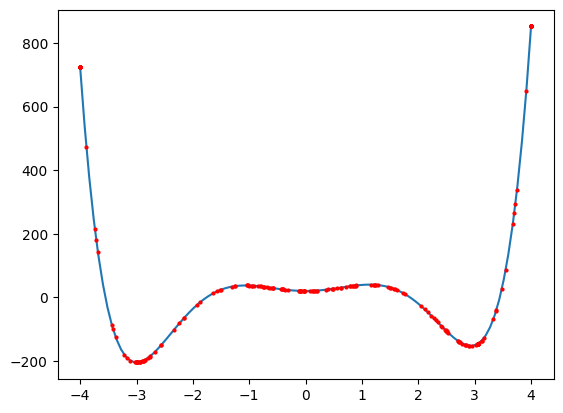

In [16]:
# Test the code with a simple math equation
if __name__ == "__main__":
    
    # Target function
    def target_function(x): 
        #return np.sum(100*(x[1:]-x[:-1]**2)**2 + (1-x[:-1])**2)   # rosenbrock
        return np.sum(x**6 -15*x**4 + x**3 + 32*x**2 + 20 )  # Use np.sum to get around the 1-D case
        
    # Plot the function
    xdat = np.linspace(-4, 4, num=100)
    ydat = [ target_function(x) for x in xdat ]
    plt.plot(xdat, ydat)

    # Find minimum point
    dim     = 1
    bounds  = np.array( [ [-4, 4] ]*dim )

    np.random.seed(0)
    opt = GAABC(target_function, bounds, 
                colony_size=5, limit=2000, max_iteration=20, 
                ga_interval=5, ga_parents=5, mutate_rate=0.2, mutat_sigma=0.05)
    best_x, best_y, all_x, all_y = opt.run(verbose=True)

    # Plot the search trajectory
    for dx,dy in zip(all_x , all_y):
        plt.plot( dx[0], dy, color='r', marker='o', ms=2 )
    plt.show
    
    print("\nBest solution found:")
    print(" x =", np.round(best_x, 4))
    print(" f =", best_y)

    print( all_x.shape, all_y.shape )

# Run test on molecular calculation

In [ ]:
from ase import Atoms
from ase.io import read, write

from scipy.spatial.transform import Rotation 
import string


class cluster_model:
    """
    This contains the other functionalities of molecular model
    molecules = list of molecules to be used. Each item is an ASE atoms obj
    number_of_molecules = list of int : number of molecules added. Shape = len(molecules)
    constraint_type = list of str: How to set bound constraints of each molecule. Shape = len(molecules)
    constraint_value = list of constraint boundary. length = len(molecules). Each item varies.
    calculator = the calculation method of energy
    """
    def __init__(self, molecules, num_of_molecules,
                 constraint_type, constraint_value,
                 calculator):
        self.molecules = molecules
        self.num_of_molecules = num_of_molecules
        self.constraint_type = constraint_type
        self.constraint_value = constraint_value
        self.calculator = calculator
        
    # prepare the molecule (atoms obj) by adding missing info
    # To ensure that "molecules" is a list of ASE atoms
    def _init_molelcules(self):
        for i, mol in enumerate(self.molecules):
            atoms = read(mol) # if list item is file name
            
            if atoms.has('residuenames'):
                pass
            else:  # Generate a random three-letter string as name
                new_resname = [i for i in string.ascii_uppercase]
                new_resname = ''.join( np.random.choice(new_resname, 3, replace=True) )
                atoms.new_array('residuenames', [new_resname]*len(atoms), str)
            self.molecules[i] = atoms

    # From constraint_type and _value, generate the bound condition for the algorithm.
    # Output: templates (shape= # of molecules in cluster), boundary ( 6*templates * tuple of 2)
    def generate_bounds(self):
        go_templates, go_boundary = [],[]
        for n in range(len(self.molecules)):
            # For each molecule, generate its bound ( list of 6 tuples, each tuple is (hi,lo))
            if self.constraint_type[n] == 'at_position':
                bound = self.constraint_value[n]
            elif self.constraint_type[n] == 'in_sphere':
                bound = self.constraint_value[n]
            else:
                print( 'Raise error' )

            go_templates += [self.molecules[n]]*num_of_molecules[n]
            go_boundary += bound*num_of_molecules[n]
    return go_templates, go_boundary

    
    # Set calculator for cluster
    def set_calculator( atoms, calculator, calc_type='internal'):
        # if using ASE calculator
        atoms.calc = calculator
        ---- run something -----
    return atoms, energy

    


In [ ]:
# Make the super-molecule
"""
Rigid body packing keeps dimensionality down. 
So we assume 6-parameter input (xyz translation and ZXZ Euler angles). 
There may be better ways.
"""
def vector_to_cluster(vec, templates):
    """
    vec : (6*templates  real-valued array, to inform the movement of molecules. 
         This is obtained from the ABC algorithm.
    templates : list of ase.Atoms (one per molecule)
    Returns an ase.Atoms super-molecule positioned & rotated.
    """
    placed, resname_of_placed, resid_of_placed = [],[], []
    for i, mol in enumerate(templates):
        t = vec[6*i : 6*i+3]  # first 3 values are XYZ translation
        euler = vec[6*i+3 : 6*i+6]  # Second 3 values are ZXZ rotation
        rot = Rotation.from_euler('zxz', euler).as_matrix()
        new_mol_xyz = mol.get_positions().dot(rot.T) + t
        m = mol.copy()
        m.set_positions(new_mol_xyz)
        placed.append(m)
        resname_of_placed.append( atoms.get_array('residuenames' )
        resid_of_placed.append( [i]*len(m) )
                                 
    cluster = Atoms(placed)  # concatenate
    cluster.new_array('residuenames', resname_of_placed, str)
    cluster.new_array('residuenumbers', resid_of_placed, str)
    
    return cluster





    

In [31]:

methane = Atoms('CH4', 
                positions=[[16.27870, 8.22867, 8.45741],
                           [16.64493, 7.86853, 7.49602],
                           [15.47292, 8.94449, 8.29484],
                           [15.90492, 7.38830, 9.04236],
                           [17.09150, 8.71388, 8.99780]],
               cell=[26.88752]*3,
               )

#print( methane.arrays )

methane = prepare_atoms(methane)
print( methane.arrays )

{'numbers': array([6, 1, 1, 1, 1]), 'positions': array([[16.2787 ,  8.22867,  8.45741],
       [16.64493,  7.86853,  7.49602],
       [15.47292,  8.94449,  8.29484],
       [15.90492,  7.3883 ,  9.04236],
       [17.0915 ,  8.71388,  8.9978 ]]), 'residuenames': array(['WAK', 'WAK', 'WAK', 'WAK', 'WAK'], dtype='<U3')}


In [32]:
def target_function(x):
    """
    pass the results of algorithm into a calculation.
    input x = vec (shape = 6*N) from algorithm step.
    output y is the energy of the structure.
    """
    # convert vec to structure
    vector_to_cluster(x, )
    return y

SyntaxError: incomplete input (3456376161.py, line 3)

In [ ]:
if __name__ == "__main__":
    
    # Target function
    def target_function(x): 
        #return np.sum(100*(x[1:]-x[:-1]**2)**2 + (1-x[:-1])**2)   # rosenbrock
        return np.sum(x**6 -15*x**4 + x**3 + 32*x**2 + 20 )  # Use np.sum to get around the 1-D case
        
    # Plot the function
    xdat = np.linspace(-4, 4, num=100)
    ydat = [ target_function(x) for x in xdat ]
    plt.plot(xdat, ydat)

    # Find minimum point
    dim     = 1
    bounds  = np.array( [ [-4, 4] ]*dim )

    np.random.seed(0)
    opt = GAABC(target_function, bounds, 
                colony_size=5, limit=2000, max_iteration=20, 
                ga_interval=5, ga_parents=5, mutate_rate=0.2, mutat_sigma=0.05)
    best_x, best_y, all_x, all_y = opt.run(verbose=True)

    # Plot the search trajectory
    for dx,dy in zip(all_x , all_y):
        plt.plot( dx[0], dy, color='r', marker='o', ms=2 )
    plt.show
    
    print("\nBest solution found:")
    print(" x =", np.round(best_x, 4))
    print(" f =", best_y)

    print( all_x.shape, all_y.shape )